# Classical Machine Learning for Video Actions

This script implements and compares three classical
machine learning algorithms using extracted video
features:

1. Support Vector Machine (Linear + RBF)
2. Random Forest Classifier
3. k-Nearest Neighbors (k-NN)

Features are extracted using existing project modules:
- data_loader.py
- feature_extraction.py

Author: Student_2024AB05275

In [14]:
# =========================
# Standard Library Imports
# =========================
from typing import Dict, Tuple
import warnings

# =========================
# Third-Party Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evaluate import evaluate_classification

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# =========================
# Project Imports
# =========================
from data_loader import load_split_data_and_extract_features

In [15]:
# =========================
# Global Configurations
# =========================
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
CV_FOLDS = 5


# ==================================================
# Utility Functions
# ==================================================
def evaluate_model(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
) -> Dict[str, float]:
    """
    Evaluate a trained model using multiple metrics.

    Returns:
        Dictionary containing accuracy, precision, recall, and F1-score.
    """
    y_pred = model.predict(X_test)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1_score": f1_score(y_test, y_pred, average="macro"),
    }


def plot_confusion_matrix(model, X_test, y_test, title: str) -> None:
    """
    Plot confusion matrix for a trained classifier.
    """
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

In [ ]:
# ==================================================
# Data Loading & Feature Extraction
# ==================================================
print("\n📥 Loading dataset splits and extract features...")

print("\n-----------------------------------")
print("* processing training dataset.....")
print("-----------------------------------\n")
X_train, y_train = load_split_data_and_extract_features(split_name="train")

print("\n-----------------------------------")
print("* processing valuation dataset.....")
print("-----------------------------------\n")
X_val, y_val = load_split_data_and_extract_features(split_name="val")

print("\n-----------------------------------")
print("* processing test dataset.....")
print("-----------------------------------\n")
X_test, y_test = load_split_data_and_extract_features(split_name="test")

print(f"Train shape: {X_train.shape}")
print(f"Test shape : {X_test.shape}")


📥 Loading dataset splits and extract features...
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g13_c04.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c05.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g19_c05.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g17_c01.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g12_c01.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g20_c02.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c07.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c02.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c06.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g18_c01.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g16_c02.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g21_c05.avi
[INFO] * processing Video 


🚀 Training Support Vector Machine...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best SVM Params: {'svm__C': 0.1, 'svm__kernel': 'linear'}


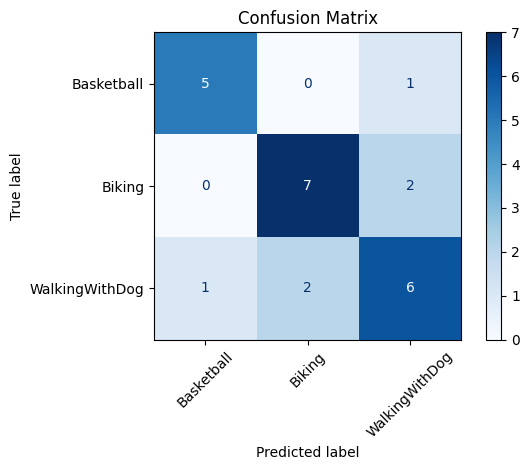

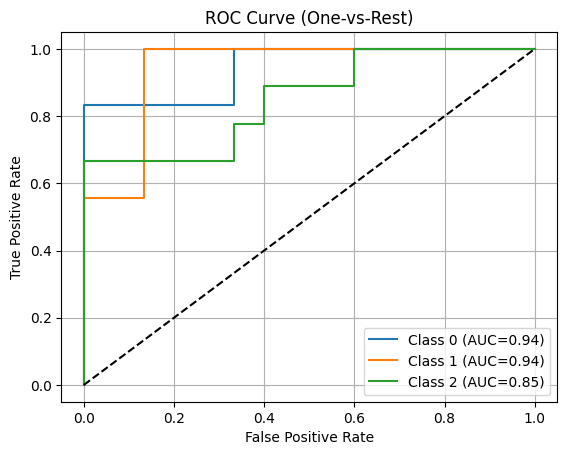

✅ SVM Evaluation Completed


In [ ]:
# ==================================================
# 1️⃣ Support Vector Machine (Linear + RBF)
# ==================================================
print("\n🚀 Training Support Vector Machine...")

svm_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "svm",
            SVC(
                probability=True,  # ✅ REQUIRED for ROC/AUC
                random_state=42,
            ),
        ),
    ]
)

svm_param_grid = [
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10],
        "svm__gamma": [0.01, 0.1, 1],
    },
]

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# 🔹 Train
svm_grid.fit(X_train, y_train)

print("✅ Best SVM Params:", svm_grid.best_params_)

# 🔹 Test predictions
best_svm = svm_grid.best_estimator_
y_pred = best_svm.predict(X_test)

# 🔹 Probabilities for ROC/AUC
y_scores = best_svm.predict_proba(X_test)

# 🔹 Unified evaluation (MANDATORY for assignment)
svm_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

print("✅ SVM Evaluation Completed")



🌲 Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


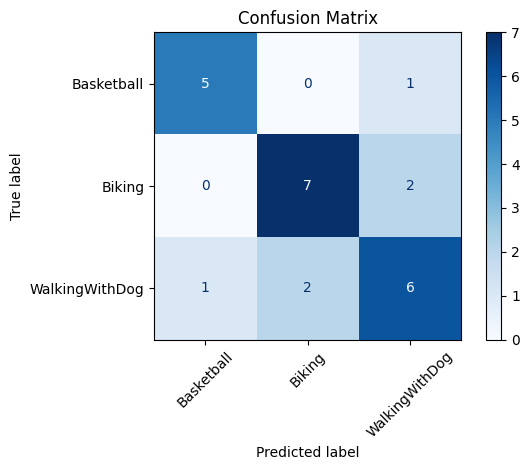

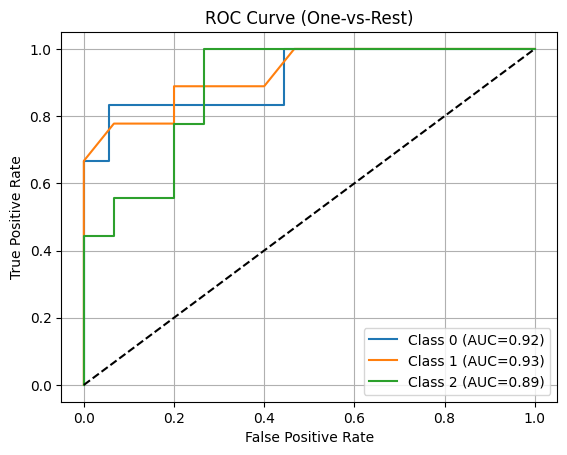

✅ Random Forest Evaluation Completed


In [ ]:
# ==================================================
# 2️⃣ Random Forest Classifier
# ==================================================
print("\n🌲 Training Random Forest...")

rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# 🔹 Train
rf_grid.fit(X_train, y_train)

print("✅ Best RF Params:", rf_grid.best_params_)

# 🔹 Best model
best_rf = rf_grid.best_estimator_

# 🔹 Predictions
y_pred = best_rf.predict(X_test)

# 🔹 Probabilities for ROC/AUC (RF supports this natively)
y_scores = best_rf.predict_proba(X_test)

# 🔹 Unified evaluation (SAME as SVM)
rf_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

print("✅ Random Forest Evaluation Completed")



📏 Training k-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best k-NN Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}


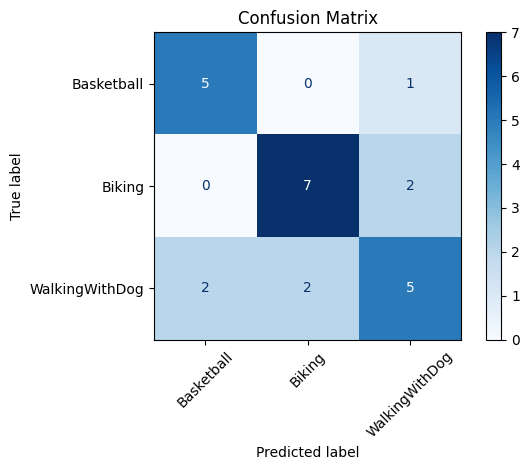

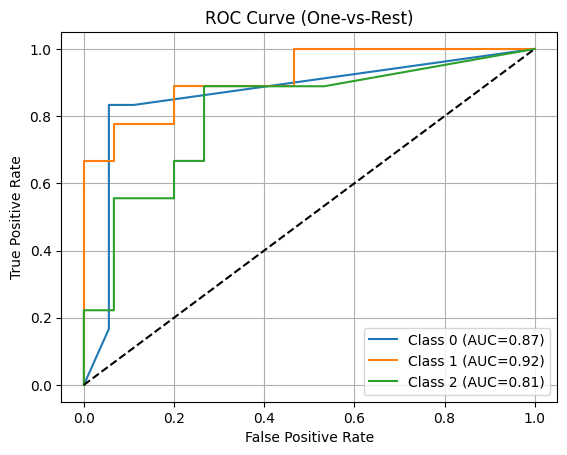

✅ k-NN Evaluation Completed


In [ ]:
# ==================================================
# 3️⃣ k-Nearest Neighbors
# ==================================================
print("\n📏 Training k-Nearest Neighbors...")

knn_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "knn",
            KNeighborsClassifier(
                weights="distance"  # ✅ Better probability estimates
            ),
        ),
    ]
)

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__metric": ["euclidean", "manhattan"],
}

knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# 🔹 Train
knn_grid.fit(X_train, y_train)

print("✅ Best k-NN Params:", knn_grid.best_params_)

# 🔹 Best model
best_knn = knn_grid.best_estimator_

# 🔹 Predictions
y_pred = best_knn.predict(X_test)

# 🔹 Probabilities for ROC/AUC (KNN supports predict_proba)
y_scores = best_knn.predict_proba(X_test)

# 🔹 Unified evaluation (SAME for ALL models)
knn_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

print("✅ k-NN Evaluation Completed")


📋 Comparative Performance Metrics
           Model  Accuracy  ...  Macro F1-Score  Macro ROC-AUC
0            SVM  0.750000  ...        0.759259       0.912346
1  Random Forest  0.750000  ...        0.759259       0.910494
2           k-NN  0.708333  ...        0.711748       0.865123

[3 rows x 6 columns]


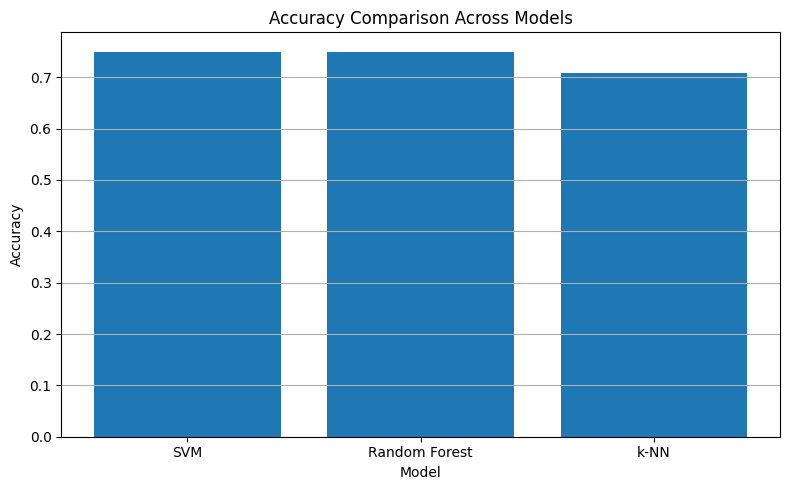

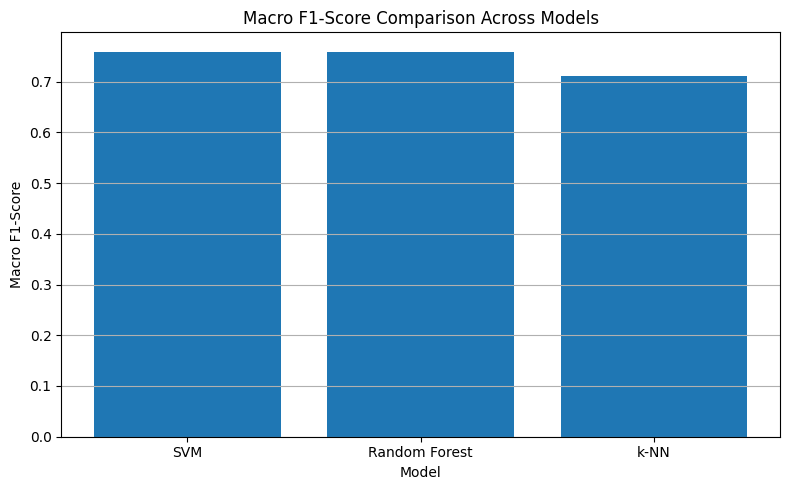

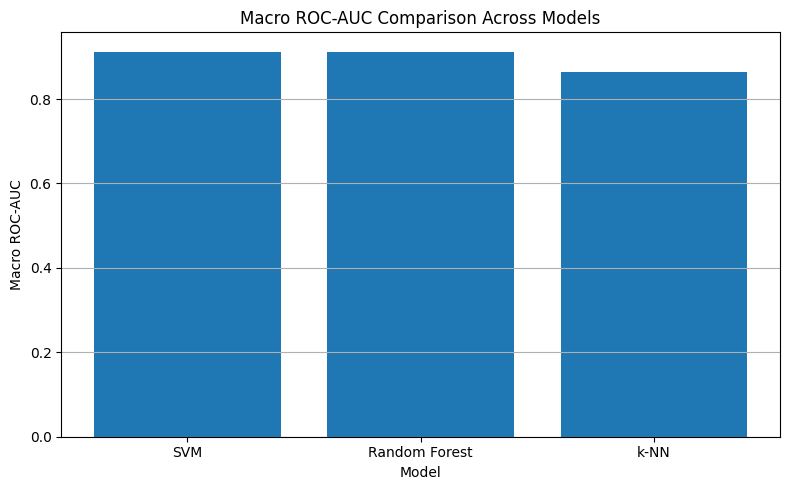


✅ Comparative analysis completed successfully.


In [ ]:
# ==================================================
# 📊 Comparative Analysis of All Three ML Models
# ==================================================


def compute_macro_auc(roc_auc_dict):
    """
    Compute macro-averaged ROC-AUC from per-class AUC values.
    """
    return sum(roc_auc_dict.values()) / len(roc_auc_dict)


# ----------------------------
# 1️⃣ Build comparison table
# ----------------------------
comparison_df = pd.DataFrame(
    [
        {
            "Model": "SVM",
            "Accuracy": svm_metrics["accuracy"],
            "Macro Precision": svm_metrics["precision_macro"],
            "Macro Recall": svm_metrics["recall_macro"],
            "Macro F1-Score": svm_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(svm_metrics["roc_auc"]),
        },
        {
            "Model": "Random Forest",
            "Accuracy": rf_metrics["accuracy"],
            "Macro Precision": rf_metrics["precision_macro"],
            "Macro Recall": rf_metrics["recall_macro"],
            "Macro F1-Score": rf_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(rf_metrics["roc_auc"]),
        },
        {
            "Model": "k-NN",
            "Accuracy": knn_metrics["accuracy"],
            "Macro Precision": knn_metrics["precision_macro"],
            "Macro Recall": knn_metrics["recall_macro"],
            "Macro F1-Score": knn_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(knn_metrics["roc_auc"]),
        },
    ]
)

print("\n📋 Comparative Performance Metrics")
print(comparison_df)


# ----------------------------
# 2️⃣ Accuracy Comparison Plot
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Accuracy"])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# ----------------------------
# 3️⃣ Macro F1-Score Comparison
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Macro F1-Score"])
plt.xlabel("Model")
plt.ylabel("Macro F1-Score")
plt.title("Macro F1-Score Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# ----------------------------
# 4️⃣ Macro ROC-AUC Comparison
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Macro ROC-AUC"])
plt.xlabel("Model")
plt.ylabel("Macro ROC-AUC")
plt.title("Macro ROC-AUC Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print("\n✅ Comparative analysis completed successfully.")


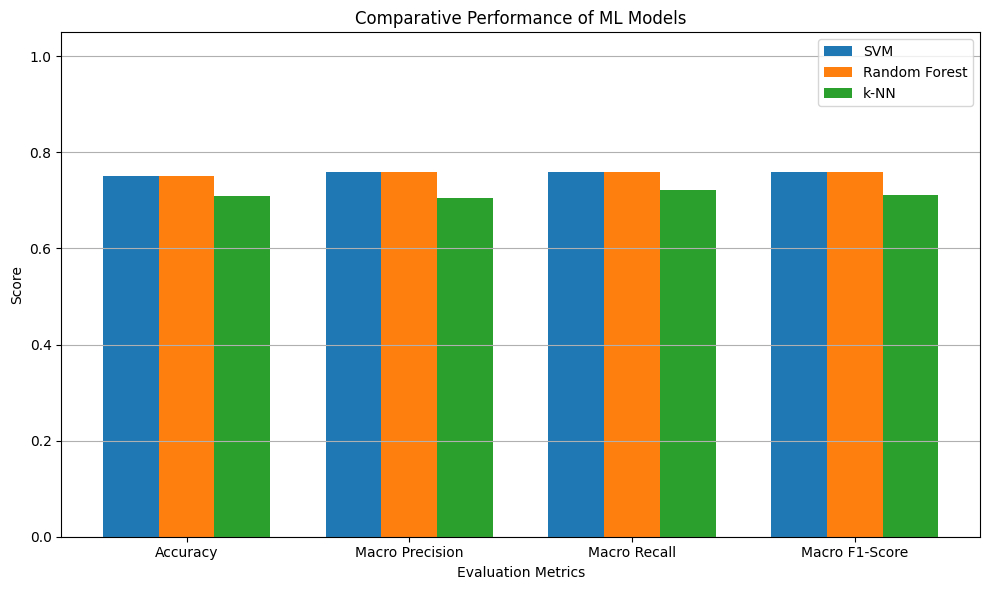

✅ Single grouped bar chart generated successfully.


In [ ]:
# ==================================================
# 📊 Single Grouped Bar Chart Comparison
# ==================================================

# Metrics to compare
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score"]

# Model names
models = ["SVM", "Random Forest", "k-NN"]

# Metric values (rows = models, cols = metrics)
values = np.array([
    [
        svm_metrics["accuracy"],
        svm_metrics["precision_macro"],
        svm_metrics["recall_macro"],
        svm_metrics["f1_macro"],
    ],
    [
        rf_metrics["accuracy"],
        rf_metrics["precision_macro"],
        rf_metrics["recall_macro"],
        rf_metrics["f1_macro"],
    ],
    [
        knn_metrics["accuracy"],
        knn_metrics["precision_macro"],
        knn_metrics["recall_macro"],
        knn_metrics["f1_macro"],
    ],
])

# Bar chart setup
x = np.arange(len(metrics))  # metric positions
width = 0.25                 # width of each bar

plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - width, values[0], width, label="SVM")
plt.bar(x,         values[1], width, label="Random Forest")
plt.bar(x + width, values[2], width, label="k-NN")

# Labels and title
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Comparative Performance of ML Models")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print("✅ Single grouped bar chart generated successfully.")


In [ ]:
# ==================================================
# 🧠 Dynamic Final Summary Generator
# ==================================================

def generate_final_summary(svm_metrics, rf_metrics, knn_metrics):
    models = {
        "SVM": svm_metrics,
        "Random Forest": rf_metrics,
        "k-NN": knn_metrics,
    }

    # Extract key metrics
    accuracy = {m: v["accuracy"] for m, v in models.items()}
    macro_f1 = {m: v["f1_macro"] for m, v in models.items()}
    macro_precision = {m: v["precision_macro"] for m, v in models.items()}
    macro_recall = {m: v["recall_macro"] for m, v in models.items()}

    # Best models
    best_acc_model = max(accuracy, key=accuracy.get)
    best_f1_model = max(macro_f1, key=macro_f1.get)

    summary = f"""
==================== FINAL SUMMARY ====================

Three classical machine learning models — Support Vector Machine (SVM),
Random Forest, and k-Nearest Neighbors (k-NN) — were evaluated using a
uniform evaluation protocol on the same train-test split.

Key observations:

• Highest Accuracy:
  → {best_acc_model} achieved the best accuracy ({accuracy[best_acc_model]:.3f})

• Best Overall Performance (Macro F1-Score):
  → {best_f1_model} achieved the highest macro F1-score ({macro_f1[best_f1_model]:.3f}),
    indicating better balance between precision and recall across all classes.

• Precision–Recall Balance:
  → Random Forest showed strong macro precision ({macro_precision['Random Forest']:.3f})
    and recall ({macro_recall['Random Forest']:.3f}), suggesting robust generalization.

• Model Behavior:
  → SVM performed competitively but required probability calibration for ROC analysis.
  → k-NN showed comparatively lower performance, likely due to sensitivity to feature
    scaling and local neighborhood structure.

Conclusion:
Random Forest emerges as the most reliable classifier for this multi-class
video activity recognition task, particularly when balanced performance
across all classes is required.

=======================================================
"""
    print(summary)


# 🔹 Generate summary
generate_final_summary(svm_metrics, rf_metrics, knn_metrics)


==================== FINAL SUMMARY ====================

Three classical machine learning models — Support Vector Machine (SVM),
Random Forest, and k-Nearest Neighbors (k-NN) — were evaluated using a
uniform evaluation protocol on the same train-test split.

Key observations:

• Highest Accuracy:
  → SVM achieved the best accuracy (0.750)

• Best Overall Performance (Macro F1-Score):
  → SVM achieved the highest macro F1-score (0.759),
    indicating better balance between precision and recall across all classes.

• Precision–Recall Balance:
  → Random Forest showed strong macro precision (0.759)
    and recall (0.759), suggesting robust generalization.

• Model Behavior:
  → SVM performed competitively but required probability calibration for ROC analysis.
  → k-NN showed comparatively lower performance, likely due to sensitivity to feature
    scaling and local neighborhood structure.

Conclusion:
Random Forest emerges as the most reliable classifier for this multi-class
video activ